## SVM for baseline

Import scientific computing, visualization, and evaluation utilities, and define RANDOM_STATE/TOPK_RATIO for reproducibility.


In [18]:
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    brier_score_loss,
)

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

RANDOM_STATE = 42
TOPK_RATIO = 0.1


## 1. Load Data

Read the cleaned churn dataset from disk and confirm the path is correct.


In [19]:
DATA_PATH = Path('churn_clean.csv')
assert DATA_PATH.exists(), f"Data file not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 2. Prepare Features & Target

Use `Exited` as the label and identify numeric vs. categorical columns for later preprocessing.


In [20]:
X = df.drop('Exited', axis=1)
y = df['Exited']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols, num_cols


(['Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

## 3. Metric Helpers

Provide reusable helpers for Precision@K/Recall@K plus the overall evaluation bundle shared by all models.


In [21]:
def topk_precision_recall(y_true, y_proba, k_ratio: float = TOPK_RATIO):
    """Compute Precision@K and Recall@K."""
    assert 0 < k_ratio <= 1, 'k_ratio must be in (0, 1].'
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    n = len(y_true)
    k = max(1, int(np.floor(n * k_ratio)))
    order = np.argsort(-y_proba)
    topk_idx = order[:k]

    y_topk = y_true[topk_idx]
    tp_at_k = y_topk.sum()
    total_pos = y_true.sum()

    precision_at_k = tp_at_k / k
    recall_at_k = tp_at_k / total_pos if total_pos > 0 else 0.0

    return {
        'K': k,
        'Precision@K': precision_at_k,
        'Recall@K': recall_at_k,
    }


def evaluate_classifier(y_true, y_proba, threshold: float = 0.5, k_ratio: float = TOPK_RATIO):
    """Return ROC-AUC, PR-AUC, F1, Balanced Accuracy, Brier Score, Precision@K/Recall@K."""
    y_true_arr = y_true.values if hasattr(y_true, 'values') else np.asarray(y_true)
    y_proba_arr = np.asarray(y_proba)
    y_pred = (y_proba_arr >= threshold).astype(int)

    metrics = {
        'ROC-AUC': roc_auc_score(y_true_arr, y_proba_arr),
        'PR-AUC': average_precision_score(y_true_arr, y_proba_arr),
        'F1': f1_score(y_true_arr, y_pred),
        'BalancedAccuracy': balanced_accuracy_score(y_true_arr, y_pred),
        'BrierScore': brier_score_loss(y_true_arr, y_proba_arr),
    }

    topk = topk_precision_recall(y_true_arr, y_proba_arr, k_ratio=k_ratio)
    metrics.update(topk)
    return metrics


## 4. 60/20/20 Split

Perform a two-step stratified split (60% train, 20% validation, 20% test) so class balance matches other baselines.


In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=RANDOM_STATE,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print('Train:', X_train.shape, 'Target ratio:', y_train.mean().round(3))
print('Validation:', X_val.shape, 'Target ratio:', y_val.mean().round(3))
print('Test:', X_test.shape, 'Target ratio:', y_test.mean().round(3))


Train: (6000, 10) Target ratio: 0.204
Validation: (2000, 10) Target ratio: 0.204
Test: (2000, 10) Target ratio: 0.204


## 5. Preprocessing & SVM Pipeline

One-hot encode categorical features, standardize numeric ones, then attach a class-weighted RBF SVM.


In [23]:
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer([
    ('categorical', ohe, cat_cols),
    ('numeric', StandardScaler(), num_cols)
])

svm_rbf_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', SVC(
        kernel='rbf',
        probability=True,
        class_weight='balanced',
        random_state=RANDOM_STATE,
    ))
])
svm_rbf_pipeline


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 6. Train The RBF SVM

Fit the full pipeline on the training split so it can be reused directly for inference.


In [24]:
svm_rbf_pipeline.fit(X_train, y_train)
svm_rbf_pipeline


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 7. Generate Validation/Test Predictions

Produce class labels and probabilities for validation and test sets as inputs for metrics and plots.


In [25]:
predictions = {}
for dataset_name, (X_split, y_split) in {
    'Validation': (X_val, y_val),
    'Test': (X_test, y_test),
}.items():
    y_pred = svm_rbf_pipeline.predict(X_split)
    y_proba = svm_rbf_pipeline.predict_proba(X_split)[:, 1]
    predictions[dataset_name] = {
        'y_true': y_split,
        'y_pred': y_pred,
        'y_proba': y_proba,
    }

predictions


{'Validation': {'y_true': 8583    0
  1924    0
  3195    0
  5263    0
  1484    0
         ..
  926     0
  6727    1
  4745    1
  1307    0
  7464    1
  Name: Exited, Length: 2000, dtype: int64,
  'y_pred': array([0, 0, 0, ..., 1, 0, 1], shape=(2000,)),
  'y_proba': array([0.12279416, 0.1275861 , 0.1931713 , ..., 0.73969925, 0.07558712,
         0.29671281], shape=(2000,))},
 'Test': {'y_true': 9167    0
  9387    0
  6859    0
  3500    0
  6233    0
         ..
  7392    0
  3233    0
  218     1
  4755    0
  7634    0
  Name: Exited, Length: 2000, dtype: int64,
  'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(2000,)),
  'y_proba': array([0.07692712, 0.05789891, 0.17076202, ..., 0.08140008, 0.03626324,
         0.04503741], shape=(2000,))}}

## 8. Aggregate Key Metrics

Collect ROC-AUC, PR-AUC, F1, Balanced Accuracy, Brier Score, and Precision@K/Recall@K in a tidy table.


In [26]:
metrics_rows = []
for dataset_name, values in predictions.items():
    metrics = evaluate_classifier(values['y_true'], values['y_proba'], k_ratio=TOPK_RATIO)
    metrics_rows.append({'Dataset': dataset_name, **metrics})

metrics_df = pd.DataFrame(metrics_rows)
metrics_df


,Dataset,ROC-AUC,PR-AUC,F1,BalancedAccuracy,BrierScore,K,Precision@K,Recall@K
0,Validation,0.858819,0.680322,0.602210,0.736378,0.106190,200,0.765,0.375000
1,Test,0.850458,0.666106,0.575843,0.720455,0.109629,200,0.770,0.378378


## 9. Classification Reports & Confusion Matrices

Print the standard classification report and store confusion matrices for visualization.


In [27]:
conf_matrices = {}
for dataset_name, values in predictions.items():
    cm = confusion_matrix(values['y_true'], values['y_pred'])
    conf_matrices[dataset_name] = cm
    print(f"SVM-RBF - {dataset_name} classification report")
    print(classification_report(values['y_true'], values['y_pred']))

conf_matrices


SVM-RBF - Validation classification report
              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1592
           1       0.49      0.78      0.60       408

    accuracy                           0.79      2000
   macro avg       0.71      0.79      0.73      2000
weighted avg       0.84      0.79      0.80      2000

SVM-RBF - Test classification report
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      1593
           1       0.48      0.73      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.78      0.80      2000



{'Validation': array([[1259,  333],
        [  89,  319]]),
 'Test': array([[1268,  325],
        [ 108,  299]])}

## 10. Figure Output Directory

Ensure the shared figure folder exists so ROC/PR/confusion plots can be saved consistently.


In [28]:
FIG_DIR = Path('figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)


## 11. Compute ROC/PR Curve Data

Cache FPR/TPR and Precision/Recall arrays for each split for downstream plotting.


In [29]:
curve_data = {}
for dataset_name, values in predictions.items():
    fpr, tpr, _ = roc_curve(values['y_true'], values['y_proba'])
    prec, rec, _ = precision_recall_curve(values['y_true'], values['y_proba'])
    auc = roc_auc_score(values['y_true'], values['y_proba'])
    ap = average_precision_score(values['y_true'], values['y_proba'])
    curve_data[dataset_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'precision': prec,
        'recall': rec,
        'auc': auc,
        'ap': ap,
    }
curve_data


{'Validation': {'fpr': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.28140704e-04,
         6.28140704e-04, 1.25628141e-03, 1.25628141e-03, 1.88442211e-03,
         1.88442211e-03, 2.51256281e-03, 2.51256281e-03, 3.14070352e-03,
         3.14070352e-03, 3.76884422e-03, 3.76884422e-03, 4.39698492e-03,
         4.39698492e-03, 5.02512563e-03, 5.02512563e-03, 5.65326633e-03,
         5.65326633e-03, 6.90954774e-03, 6.90954774e-03, 7.53768844e-03,
         7.53768844e-03, 8.16582915e-03, 8.16582915e-03, 8.79396985e-03,
         8.79396985e-03, 9.42211055e-03, 9.42211055e-03, 1.00502513e-02,
         1.00502513e-02, 1.25628141e-02, 1.25628141e-02, 1.38190955e-02,
         1.38190955e-02, 1.44472362e-02, 1.44472362e-02, 1.50753769e-02,
         1.50753769e-02, 1.63316583e-02, 1.63316583e-02, 1.75879397e-02,
         1.75879397e-02, 1.82160804e-02, 1.82160804e-02, 2.01005025e-02,
         2.01005025e-02, 2.07286432e-02, 2.07286432e-02, 2.13567839e-02,
         2.13567839e-02, 2.261

## 12. Plot ROC Curves

Compare validation and test ROC curves to inspect generalization.


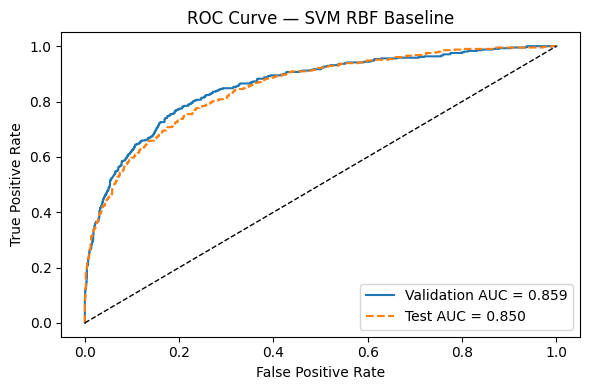

In [30]:
plt.figure(figsize=(6, 4))
for dataset_name, roc_info in curve_data.items():
    linestyle = '-' if dataset_name == 'Validation' else '--'
    plt.plot(roc_info['fpr'], roc_info['tpr'], linestyle=linestyle, label=f"{dataset_name} AUC = {roc_info['auc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — SVM RBF Baseline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve_svm_rbf.png', dpi=200)
plt.show()


## 13. Plot Precision-Recall Curves

Show the recall–precision trade-off on each split.


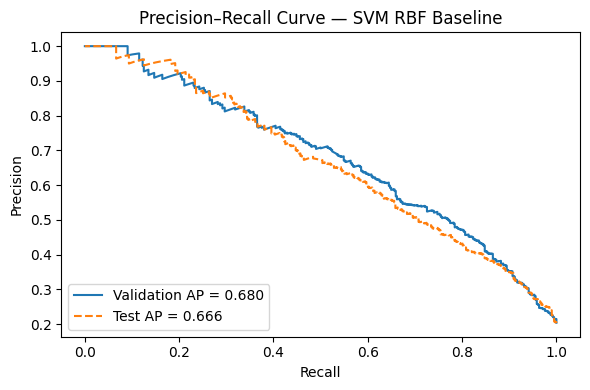

In [31]:
plt.figure(figsize=(6, 4))
for dataset_name, pr_info in curve_data.items():
    linestyle = '-' if dataset_name == 'Validation' else '--'
    plt.plot(pr_info['recall'], pr_info['precision'], linestyle=linestyle, label=f"{dataset_name} AP = {pr_info['ap']:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve — SVM RBF Baseline')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(FIG_DIR / 'pr_curve_svm_rbf.png', dpi=200)
plt.show()


## 14. Plot Confusion Matrices

Visualize validation/test confusion matrices to highlight misclassification patterns.


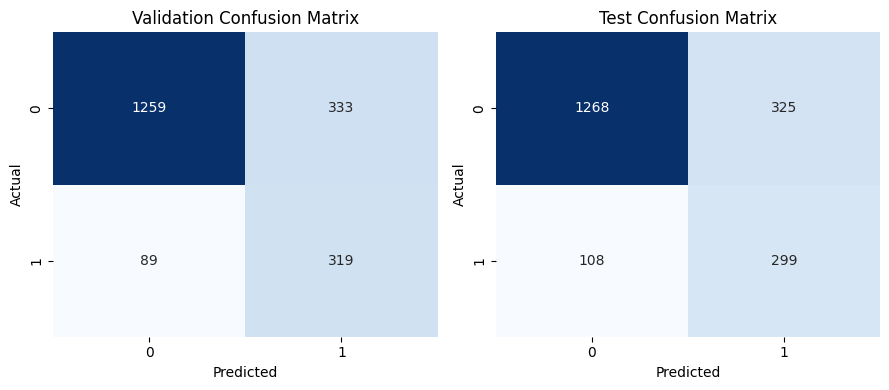

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for ax, dataset_name in zip(axes, ['Validation', 'Test']):
    sns.heatmap(conf_matrices[dataset_name], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{dataset_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrices_svm_rbf.png', dpi=200)
plt.show()


## 15. Export Metrics & Predictions

Write the aggregated metrics and per-sample predictions to CSV for downstream comparison.


In [33]:
OUTPUT_DIR = Path('reports')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(OUTPUT_DIR / 'svm_rbf_metrics_en.csv', index=False)

pred_rows = []
for dataset_name, values in predictions.items():
    pred_rows.append(pd.DataFrame({
        'dataset': dataset_name,
        'y_true': values['y_true'].values,
        'y_proba': values['y_proba'],
    }))
pred_df = pd.concat(pred_rows, ignore_index=True)
pred_df.to_csv(OUTPUT_DIR / 'svm_rbf_predictions_en.csv', index=False)

print('Saved metrics and predictions to', OUTPUT_DIR)


Saved metrics and predictions to reports


## 16. Persist The Trained Pipeline

Save the complete SVM pipeline as a joblib artifact for deployment or reuse.


In [34]:
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / 'svm_rbf_baseline.joblib'
joblib.dump(svm_rbf_pipeline, MODEL_PATH)
MODEL_PATH


PosixPath('models/svm_rbf_baseline.joblib')